In [1]:
# Credits (More developed later)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from os import walk
from Covariance_Cleaner import TrueCovEst
# For future work I will use linear imputation for missing datafrom os import walk

In [2]:
# If you already have a table of prices, you may name
# it CloseTable.csv and use it directly by setting
# Clostable=True.
def CreateTable(CloseTable = False):
    if (CloseTable==False):
        # Read all individual stock info, and save their prices
        # into one single dataframe
        filenames = next(walk("DataFin/stocks/"), (None, None, []))[2]  # [] if no file
        d = {}
        for i in range(len(filenames)):
            filenames[i] = filenames[i].replace(".csv","")
            pathnames = "DataFin/stocks/" + filenames[i] + ".csv"
            d[filenames[i]] = pd.read_csv(pathnames)

        adj_close_vals = list()

        for stock_df in d:
            adj_close_vals.append(d[stock_df]['Close'])

        stocks = pd.concat(adj_close_vals, axis = 1)
        stocks.columns = filenames
        stocks.to_csv("DataFin/CloseTable.csv")
    return(filenames)

In [3]:
def MissingHandler(stocks, imputer="Iterative"):
    # Impute missing values from stocks dataframe
    # If not Iterative or KNN, simple imputation will be used
    countnan = np.sum(stocks.isna().sum())
    if (imputer=="Iterative"):
        if (countnan < (len(stocks.columns)*len(stocks.index) *0.1)):
                imp = IterativeImputer(max_iter=10, random_state=0)
                stocks = imp.fit_transform(stocks)   
                stocks = pd.DataFrame(stocks)
        else:
            print("Too many missing values, proper cleaning is required.")
    elif (imputer=="KNN"):
        if (countnan < (len(stocks.columns)*len(stocks.index) *0.1)):
            imp = KNNImputer(n_neighbors=10, weights="uniform")
            stocks = imp.fit_transform(stocks)
            stocks = pd.DataFrame(stocks)   
        else:
            print("Too many missing values, proper cleaning is required.")
    else:
        if (countnan < (len(stocks.columns)*len(stocks.index) *0.1)):
            imp = SimpleImputer(missing_values=np.nan, strategy='mean')
            stocks = imp.fit_transform(stocks)
            stocks = pd.DataFrame(stocks) 
        else:
            print("Too many missing values, proper cleaning is required.")   
    return(stocks)

(148, 148)
Expected total return:  24.009806232828513


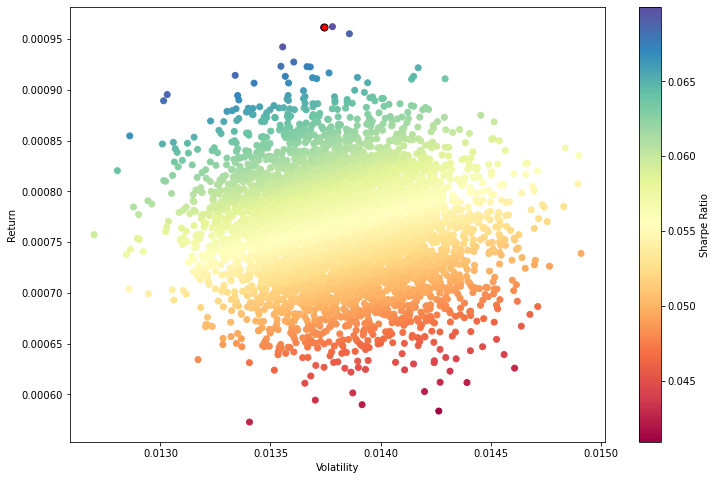

In [4]:
# imputer="KNN"
Capital = 500000
QuEST = True

filenames = CreateTable()
# Read csv with the close Table prices
stocks = pd.read_csv("DataFin/CloseTable.csv", index_col=0)
stocks.drop(stocks.tail(1).index,inplace=True) # drop last row
# Run an imputer for missing data
stocks = MissingHandler(stocks)

# Get logarithmic returns
log_returns = np.log(stocks/stocks.shift(1))
n_In=log_returns.shape[0]

# Set random values for the stock portfolio so long as they sum one. 
# You may also restrict the values to just positives.
np.random.seed(101)
num_ports = 5000
all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
shortstocking=False

if (QuEST==True):
    # This is the QUEST Covariance Estimator
    CovEsti = TrueCovEst(log_returns.cov(), n_In)
else:
    CovEsti = log_returns.cov()

# Recommended: False
if(shortstocking==False):
    # Just positive weights
    for ind in range(num_ports):
        weights = np.array(np.random.random(len(stocks.columns)))
        weights = weights / np.sum(weights)
        # SR is the metric used, but you can use others
        # such as min standard deviation, max return.
        # For that you may modify the lines from here: ###########################
        ret_arr[ind] = np.sum((log_returns.mean() * weights))

        vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(CovEsti, weights)))
        sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]
        all_weights[ind,:] = weights
else:
    # Any weights
    for ind in range(num_ports):
        signs = np.zeros(len(stocks.columns))
        for i in range(len(stocks.columns)):
            if np.random.random() < 0.5:
                signs[i] = 1
            else:
                signs[i] = -1
        weights_unsigned = np.array(np.random.random(len(stocks.columns)))
        weights = weights_unsigned*signs
        # Ensures that you have the capital to take the loss.
        weights = weights / np.sum(weights_unsigned)
        # SR is the metric used, but you can use others
        # such as min standard deviation, max return.
        # For that you may modify the lines from here: ###########################
        ret_arr[ind] = np.sum((log_returns.mean() * weights))
        vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(CovEsti, weights)))
        sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]
        all_weights[ind,:] = weights_unsigned
        
# Print optimal weights
# print(all_weights[sharpe_arr.argmax(),:])
allo = all_weights[sharpe_arr.argmax(),:]
# To here. ###############################################################

c2 = np.array(stocks) @ allo 
stocks['Total Pos'] = c2 * Capital
cumulative_return = 100*(stocks['Total Pos'].iloc[-2]/stocks['Total Pos'].iloc[0]-1)
print('Expected total return: ', cumulative_return)

# If plotdata is True, plot the frontier graph
plotdata=True
if (plotdata==True):
    plt.figure(figsize = (12,8))
    plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='Spectral')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')

    # Add red dot for max SR
    max_sr_ret = ret_arr[sharpe_arr.argmax()]
    max_sr_vol = vol_arr[sharpe_arr.argmax()]
    plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')
    plt.savefig("DataFin/EfficientFrontier.png");